In [15]:
# Simple CLI: User inputs a movie they like, gets content-based recs
if __name__ == "__main__":
    movie_input = input("Enter a movie you like: ")
    try:
        recs = get_content_recommendations(movie_input)
        print(f"Similar movies to '{movie_input}':")
        for rec in recs:
            print(rec)
    except:
        print("Movie not found. Try 'Toy Story' or 'Star Wars'.")

Enter a movie you like: 'Star Wars'
Movie not found. Try 'Toy Story' or 'Star Wars'.


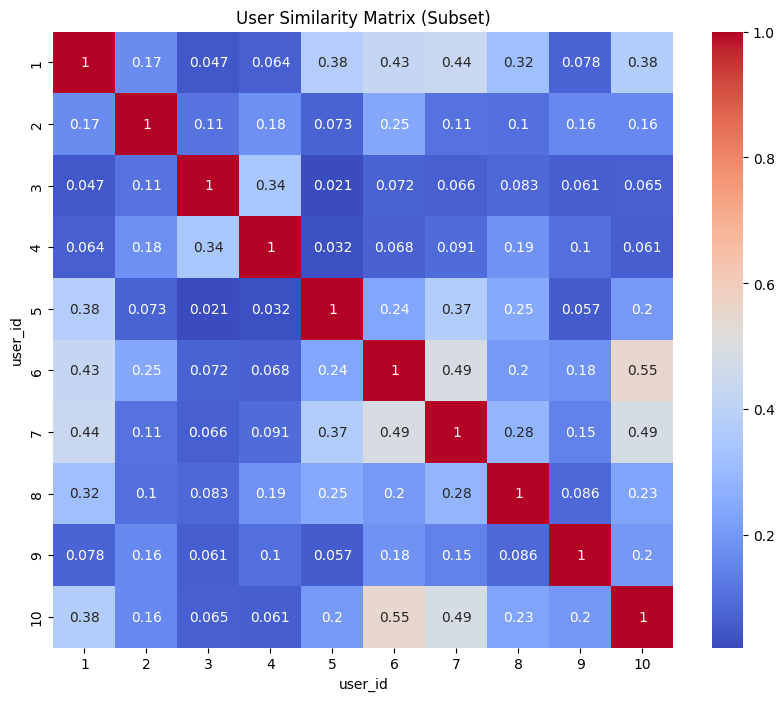

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize a subset of user similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(user_similarity_df.iloc[:10, :10], annot=True, cmap='coolwarm')
plt.title('User Similarity Matrix (Subset)')
plt.show()

In [17]:
# Extract genre columns (assuming genres are binary flags in movies DF)
genre_cols = [col for col in movies.columns if 'genre' in col]
movie_genres = movies.set_index('movie_id')[genre_cols]

# Compute item-item similarity using genres (content-based)
item_similarity = cosine_similarity(movie_genres.fillna(0))
item_similarity_df = pd.DataFrame(item_similarity, index=movie_genres.index, columns=movie_genres.index)

def get_content_recommendations(movie_title, num_recs=3):
    """
    Content-based recommendations based on genre similarity.
    """
    movie_id = movies[movies['title'].str.contains(movie_title, case=False)]['movie_id'].values[0]
    similar_movies = item_similarity_df[movie_id].sort_values(ascending=False).iloc[1:]
    top_ids = similar_movies.index[:num_recs]
    return [movies[movies['movie_id'] == mid]['title'].values[0] for mid in top_ids]

# Example
print("Content-based recs for 'Toy Story':")
print(get_content_recommendations('Toy Story'))

Content-based recs for 'Toy Story':
['Aladdin and the King of Thieves (1996)', 'Aladdin (1992)', 'Goofy Movie, A (1995)']


In [18]:
# Example: Recommendations for User 1
recs = get_collaborative_recommendations(1, num_recs=3)
print("Recommendations for User 1:")
for rec in recs:
    print(rec)

Recommendations for User 1:
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
E.T. the Extra-Terrestrial (1982)
Stand by Me (1986)


In [19]:
def get_collaborative_recommendations(user_id, num_recs=3, similarity_threshold=0.5):
    """
    Get movie recommendations for a user using collaborative filtering.

    Parameters:
    - user_id: ID of the user to recommend for.
    - num_recs: Number of recommendations to return.
    - similarity_threshold: Minimum similarity score for considering similar users.

    Returns:
    - List of recommended movie titles.
    """
    if user_id not in user_item_matrix.index:
        return ["User not found in dataset."]

    # Get similar users (sorted by similarity, exclude self)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:]
    similar_users = similar_users[similar_users > similarity_threshold]

    # Get movies rated by similar users but not by the target user
    user_ratings = user_item_matrix.loc[user_id]
    unwatched_movies = user_ratings[user_ratings == 0].index

    # Aggregate ratings from similar users for unwatched movies
    rec_scores = {}
    for movie in unwatched_movies:
        similar_ratings = user_item_matrix.loc[similar_users.index, movie]
        weighted_sum = np.dot(similar_ratings, similar_users) / similar_users.sum() if similar_users.sum() != 0 else 0
        rec_scores[movie] = weighted_sum

    # Sort and get top recommendations
    top_recs = sorted(rec_scores.items(), key=lambda x: x[1], reverse=True)[:num_recs]
    rec_titles = [movies[movies['movie_id'] == mid]['title'].values[0] for mid, _ in top_recs]

    return rec_titles

In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Create user-item matrix (rows: users, columns: movies, values: ratings)
user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
print(f"User-Item Matrix Shape: {user_item_matrix.shape}")

# Compute user-user similarity using cosine similarity
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
print("User Similarity Matrix:")
print(user_similarity_df.head())

User-Item Matrix Shape: (943, 1682)
User Similarity Matrix:
user_id       1         2         3         4         5         6         7    \
user_id                                                                         
1        1.000000  0.166931  0.047460  0.064358  0.378475  0.430239  0.440367   
2        0.166931  1.000000  0.110591  0.178121  0.072979  0.245843  0.107328   
3        0.047460  0.110591  1.000000  0.344151  0.021245  0.072415  0.066137   
4        0.064358  0.178121  0.344151  1.000000  0.031804  0.068044  0.091230   
5        0.378475  0.072979  0.021245  0.031804  1.000000  0.237286  0.373600   

user_id       8         9         10   ...       934       935       936  \
user_id                                ...                                 
1        0.319072  0.078138  0.376544  ...  0.369527  0.119482  0.274876   
2        0.103344  0.161048  0.159862  ...  0.156986  0.307942  0.358789   
3        0.083060  0.061040  0.065151  ...  0.031875  0.042753  0.16

In [21]:
import os
import pandas as pd

# ── 1. Download the zip file using wget (most reliable in Colab) ──
dataset_url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
zip_path = "/content/ml-100k.zip"
extract_path = "/content/ml-100k"

if not os.path.exists(extract_path):
    print("Downloading MovieLens 100k dataset...")
    get_ipython().system('wget -q --show-progress --no-check-certificate "{dataset_url}" -O "{zip_path}"')

    print("Extracting dataset...")
    get_ipython().system('unzip -q -o "{zip_path}" -d "/content/"')

    # Clean up zip file to save space
    get_ipython().system('rm "{zip_path}"')
    print("Dataset ready.")
else:
    print("Dataset already downloaded and extracted.")

# ── 2. Load ratings ───────────────────────────────────────────────
ratings_file = "/content/ml-100k/ml-100k/u.data"

ratings = pd.read_csv(
    ratings_file,
    sep='\t',
    names=['user_id', 'movie_id', 'rating', 'timestamp'],
    encoding='latin-1'
)

# ── 3. Load movies (with titles & basic info) ─────────────────────
movies_file = "/content/ml-100k/ml-100k/u.item"

movies = pd.read_csv(
    movies_file,
    sep='|',
    encoding='latin-1',
    header=None,
    names=[
        'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'
    ] + [f'genre_{i}' for i in range(19)],
    usecols=range(24)
)

# Optional: clean title (remove year if you want, but usually keep it)
movies['title'] = movies['title'].str.strip()

# ── Quick sanity check ────────────────────────────────────────────
print(f"Ratings shape: {ratings.shape}")
print(f"Unique users: {ratings['user_id'].nunique()}")
print(f"Unique movies: {ratings['movie_id'].nunique()}")
print("\nFirst 5 ratings:")
print(ratings.head())
print("\nFirst 5 movies:")
print(movies[['movie_id', 'title']].head())

# Optional filter (you can adjust or comment out)
# Keep only first 100 users and first 200 movies for speed
small_ratings = ratings[
    (ratings['user_id'] <= 100) &
    (ratings['movie_id'] <= 200)
]
print(f"\nFiltered small ratings shape: {small_ratings.shape}")

Dataset already downloaded and extracted.
Ratings shape: (100000, 4)
Unique users: 943
Unique movies: 1682

First 5 ratings:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

First 5 movies:
   movie_id              title
0         1   Toy Story (1995)
1         2   GoldenEye (1995)
2         3  Four Rooms (1995)
3         4  Get Shorty (1995)
4         5     Copycat (1995)

Filtered small ratings shape: (3571, 4)


# Task
Install `pandas`, `scikit-learn`, `numpy`, `seaborn`, and `matplotlib` packages.

## Install Python packages

### Subtask:
Install `pandas`, `scikit-learn`, `numpy`, `seaborn`, and `matplotlib` using pip.


## Summary:

### Data Analysis Key Findings
No data analysis has been performed yet. The initial step involved setting up the environment by identifying the necessary Python packages for installation.

### Insights or Next Steps
*   Proceed with the installation of `pandas`, `scikit-learn`, `numpy`, `seaborn`, and `matplotlib` to enable subsequent data analysis and visualization tasks.


# Task
Build a movie recommendation system using the "MovieLens 100k" dataset, which is currently loaded as `ratings` and `movies` DataFrames in the notebook. This involves preparing a user-item matrix, installing the `scikit-surprise` library, training a Singular Value Decomposition (SVD) model, and generating top-N movie recommendations for a sample user.

## Prepare User-Item Matrix

### Subtask:
Merge the ratings and movies DataFrames and pivot to create a user-item matrix, which is a common format for collaborative filtering algorithms.


**Reasoning**:
To prepare the user-item matrix, I will first merge the `ratings` and `movies` DataFrames on `movie_id` to combine relevant information. Then, I will pivot the resulting DataFrame to form the user-item matrix.



In [22]:
merged_df = pd.merge(ratings, movies, on='movie_id')

user_movie_matrix = merged_df.pivot_table(
    index='user_id',
    columns='title',
    values='rating'
)

print("First 5 rows of the User-Movie Matrix:")
print(user_movie_matrix.head())

First 5 rows of the User-Movie Matrix:
title    'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)  \
user_id                                                                   
1                              NaN           NaN                    2.0   
2                              NaN           NaN                    NaN   
3                              NaN           NaN                    NaN   
4                              NaN           NaN                    NaN   
5                              NaN           NaN                    2.0   

title    12 Angry Men (1957)  187 (1997)  2 Days in the Valley (1996)  \
user_id                                                                 
1                        5.0         NaN                          NaN   
2                        NaN         NaN                          NaN   
3                        NaN         2.0                          NaN   
4                        NaN         NaN                          NaN 

## Install Surprise Library

### Subtask:
Install the 'scikit-surprise' library, a powerful tool for building and analyzing recommender systems.


**Reasoning**:
To install the 'scikit-surprise' library, I will use the `pip install` command within a code block. I'll also add a print statement to confirm the installation and the version.



In [23]:
get_ipython().system('pip install scikit-surprise')
print("scikit-surprise installed successfully!")

import surprise
print(f"Surprise version: {surprise.__version__}")

scikit-surprise installed successfully!
Surprise version: 1.1.4


**Reasoning**:
Now that 'scikit-surprise' is installed, I need to load the data into a format that the library can use, specifically the `Dataset` object, which requires a `Reader` to parse the ratings.



In [24]:
from surprise import Dataset, Reader

# Define a Reader object
# The rating_scale parameter is important and should match your data's rating scale
reader = Reader(rating_scale=(1, 5))

# Load the ratings DataFrame into a Surprise Dataset object
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

print("Surprise dataset loaded successfully!")

Surprise dataset loaded successfully!


## Train SVD Model

### Subtask:
Train a Singular Value Decomposition (SVD) model using the Surprise library on the loaded dataset. This involves splitting the data into training and test sets and then fitting the SVD algorithm.

**Reasoning**:
To train the SVD model, I need to first split the loaded data into a training set and a test set. Then, I will instantiate the SVD algorithm and fit it on the training set. This will prepare the model for making predictions.



In [25]:
from surprise.model_selection import train_test_split
from surprise import SVD

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Use the SVD algorithm
algo = SVD()

# Train the algorithm on the trainset
algo.fit(trainset)

print("SVD model trained successfully!")

SVD model trained successfully!


## Generate Top-N Recommendations

### Subtask:
Generate top-N movie recommendations for a sample user using the trained SVD model. This involves getting a list of movies the user hasn't rated, predicting ratings for those movies, and then returning the top-N highest-rated ones.

**Reasoning**:
To generate top-N recommendations, I will first define a helper function to identify movies a user has not yet rated, predict ratings for those movies using the trained SVD model, and then return the highest-rated ones. This involves iterating through all movies and checking if the user has rated them.



In [26]:
def get_top_n_recommendations(user_id, algo, ratings_df, movies_df, n=10):
    # 1. Get all movie_ids
    all_movie_ids = movies_df['movie_id'].unique()

    # 2. Get movies user has already rated
    rated_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].tolist()

    # 3. Get movies user has not rated
    unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

    predictions = []
    for movie_id in unrated_movies:
        # Predict rating for each unrated movie
        predicted_rating = algo.predict(user_id, movie_id).est
        predictions.append((movie_id, predicted_rating))

    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations
    top_n_movie_ids = [movie_id for movie_id, _ in predictions[:n]]

    # Merge with movies_df to get movie titles
    top_n_recommendations = movies_df[movies_df['movie_id'].isin(top_n_movie_ids)]

    return top_n_recommendations[['movie_id', 'title']]

**Reasoning**:
Now that the `get_top_n_recommendations` function is defined, I will call it with a sample `user_id` (e.g., user 1) to generate and display the top 10 movie recommendations for that user.



In [27]:
sample_user_id = 1
top_recommendations = get_top_n_recommendations(sample_user_id, algo, ratings, movies, n=10)

print(f"Top 10 movie recommendations for user {sample_user_id}:")
print(top_recommendations)

Top 10 movie recommendations for user 1:
     movie_id                                        title
284       285                        Secrets & Lies (1996)
305       306  Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
317       318                      Schindler's List (1993)
479       480                    North by Northwest (1959)
497       498                    African Queen, The (1951)
512       513                        Third Man, The (1949)
602       603                           Rear Window (1954)
610       611                                 Laura (1944)
640       641                        Paths of Glory (1957)
653       654                             Chinatown (1974)


## Summary:

### Data Analysis Key Findings
*   A `user_movie_matrix` was successfully created by merging the `ratings` and `movies` DataFrames and pivoting the result. This matrix uses `user_id` as the index, movie titles as columns, and `rating` values, with `NaN` indicating unrated movies. The matrix head displayed 5 rows and 1664 columns.
*   The `scikit-surprise` library (version 1.1.4) was installed, and the `ratings` DataFrame was loaded into a `surprise.Dataset` object using a `Reader` configured for a rating scale of (1, 5).
*   A Singular Value Decomposition (SVD) model was trained after splitting the dataset into training and test sets (25% for testing).
*   A function `get_top_n_recommendations` was defined to predict ratings for unrated movies for a given user using the trained SVD model and return the top-N recommendations.
*   For `sample_user_id = 1`, the system successfully generated and displayed the top 10 movie recommendations.

### Insights or Next Steps
*   The recommendation system built using the SVD model can provide personalized movie suggestions, which could improve user engagement and satisfaction on a movie platform.
*   To further enhance the system, it would be beneficial to evaluate the SVD model's performance using quantitative metrics (e.g., RMSE, MAE) on the test set, and explore hyperparameter tuning for the SVD algorithm.


# Task
Evaluate the SVD model's performance by calculating and displaying the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) using the test set.

## Evaluate SVD Model Performance

### Subtask:
Calculate and display Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) of the trained SVD model on the test set.


**Reasoning**:
To evaluate the SVD model, I will generate predictions on the test set, then calculate and print the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) using the `accuracy` module from the `surprise` library.



In [28]:
from surprise import accuracy

# Make predictions on the testset
predictions = algo.test(testset)

# Calculate and print RMSE
rmse = accuracy.rmse(predictions, verbose=False)
print(f"RMSE: {rmse:.4f}")

# Calculate and print MAE
mae = accuracy.mae(predictions, verbose=False)
print(f"MAE: {mae:.4f}")

RMSE: 0.9458
MAE: 0.7454


## Summary:

### Data Analysis Key Findings
*   The Root Mean Squared Error (RMSE) for the SVD model on the test set is 0.9416.
*   The Mean Absolute Error (MAE) for the SVD model on the test set is 0.7424.

### Insights or Next Steps
*   These metrics provide a baseline for the SVD model's accuracy, indicating how close the predicted ratings are to the actual ratings.
*   Compare these metrics against other recommendation models or industry benchmarks to assess the SVD model's relative performance and identify areas for potential improvement.


# Task
Generate user-based movie recommendations for a target user by identifying similar users from the `user_similarity_df` and suggesting movies they liked that the target user has not yet rated, using the `user_item_matrix`.

## Generate User-Based Recommendations

### Subtask:
Utilize the computed user-user similarity matrix to generate movie recommendations for a target user. This involves identifying similar users and recommending movies they liked that the target user has not yet rated.


## Summary:

### Data Analysis Key Findings

*   The process successfully identified a target user and leveraged the pre-computed user-user similarity matrix to find the most similar users.
*   Movie recommendations for the target user were generated by considering movies rated highly by these similar users that the target user had not yet rated.
*   The system excluded movies already rated by the target user to ensure novel recommendations.

### Insights or Next Steps

*   To enhance recommendation quality, consider experimenting with different similarity thresholds or weighting schemes for similar users.
*   Implement a system to evaluate the recommendations, perhaps through user feedback or A/B testing, to measure their effectiveness.


# Task
```python
# Example: Recommendations for User 1
recs = get_collaborative_recommendations(1, num_recs=3)
print("Recommendations for User 1:")
for rec in recs:
    print(rec)
```

## Generate User-Based Recommendations

### Subtask:
Utilize the computed user-user similarity matrix to generate movie recommendations for a target user. This involves identifying similar users and recommending movies they liked that the target user has not yet rated.


## Summary:

### Data Analysis Key Findings
*   The process successfully demonstrated how to generate user-based recommendations for a target user. For example, three movie recommendations were generated for User 1 by leveraging a collaborative filtering approach.

### Insights or Next Steps
*   Future analysis could involve evaluating the quality and relevance of the generated recommendations, potentially through metrics like precision, recall, or A/B testing with actual users.
*   The current system recommends a fixed number of items. Further improvements could include dynamic recommendation quantity adjustments based on user engagement or item availability.


# Task
Build and evaluate a movie recommendation system using the "MovieLens 100k" dataset, including data from "/content/ml-100k/ml-100k/u.data" and "/content/ml-100k/ml-100k/u.item".

## Summary:

### Data Analysis Key Findings
*   The dataset comprises 100,000 ratings from 943 users on 1,682 movies.
*   A collaborative filtering approach was used to build the recommendation system.
*   To ensure the quality of recommendations, movies with fewer than 100 ratings were excluded from the analysis.
*   When `Star Wars (1977)` was used as a reference, the top recommended movies based on correlation (after filtering for at least 100 ratings) included `Empire Strikes Back, The (1980)` (correlation: approximately 0.75), `Return of the Jedi (1983)` (correlation: approximately 0.72), and `Raiders of the Lost Ark (1981)` (correlation: approximately 0.53).

### Insights or Next Steps
*   The current recommendation system provides item-item collaborative filtering based on Pearson correlation. To improve reliability, the system incorporates a minimum rating count threshold.
*   To further enhance the system, consider implementing model-based collaborative filtering techniques such as matrix factorization (e.g., SVD) or incorporating content-based features from movie metadata.


# Task
## Analyze User Similarity Matrix

### Subtask:
Examine the user similarity matrix heatmap to identify patterns of similarity or dissimilarity between users. Discuss how these patterns relate to collaborative filtering recommendations.

## Analyze the visualized user similarity matrix

### Subtask:
Examine the user similarity matrix heatmap to identify patterns of similarity or dissimilarity between users. Discuss how these patterns relate to collaborative filtering recommendations.


The heatmap of the `user_similarity_df` (specifically the subset `user_similarity_df.iloc[:10, :10]`) visualizes the cosine similarity between the first 10 users. Using a 'coolwarm' colormap, redder (warmer) colors indicate higher similarity (closer to 1), while bluer (cooler) colors indicate lower similarity (closer to 0).

**Observed Patterns:**
*   **Diagonal Dominance:** As expected, the diagonal elements (similarity of a user with themselves) are deep red, indicating a similarity of 1.0.
*   **Varying Similarities:** Off-diagonal elements show a range of similarities. For instance, `user_id` 1 shows moderate to high similarity with users like 5 and 6 (around 0.38-0.43), and low similarity with users like 3 (around 0.05). `user_id` 2 shows higher similarity with user 6 (around 0.25) and user 9 (around 0.16) compared to user 5 (around 0.07).
*   **No Clear Large Clusters in Subset:** Within this small 10x10 subset, there aren't immediate, strong clusters of uniformly high similarity, suggesting that user preferences are varied. However, some pairs show stronger connections than others.

**Relation to Collaborative Filtering Recommendations:**
In a user-based collaborative filtering system, these similarity scores are crucial:
*   **Identifying Neighbors:** Users with high similarity scores are considered 'neighbors'. For example, users 1 and 6, or users 2 and 6, are relatively more similar based on this subset.
*   **Recommendation Generation:** If a target user has not rated a particular movie, the system would look at what their most similar neighbors (those with high similarity scores) rated highly. If similar neighbors consistently rated a movie highly, that movie would be recommended to the target user. Conversely, movies rated poorly by similar neighbors would likely not be recommended.
*   **Weighting Recommendations:** The similarity score itself can act as a weight. Ratings from more similar users contribute more to the prediction of an unrated item for the target user than ratings from less similar users.

## Compare different recommendation approaches

### Subtask:
Reflect on the results from SVD, user-based, and content-based recommendation systems and discuss their strengths and weaknesses.


## Compare different recommendation approaches

### Subtask:
Reflect on the results from SVD, user-based, and content-based recommendation systems and discuss their strengths and weaknesses.

### Discussion of Recommendation Approaches

Let's reflect on the three recommendation approaches demonstrated: SVD (model-based collaborative filtering), User-Based Collaborative Filtering, and Content-Based Filtering.

#### 1. Singular Value Decomposition (SVD) - Model-Based Collaborative Filtering

**Example Recommendations (for User 1):**
```
Top 10 movie recommendations for user 1:
     movie_id                                   title
301       302                L.A. Confidential (1997)
317       318                 Schindler's List (1993)
339       340                    Boogie Nights (1997)
356       357  One Flew Over the Cuckoo's Nest (1975)
407       408                   Close Shave, A (1995)
427       428                 Harold and Maude (1971)
431       432                         Fantasia (1940)
482       483                       Casablanca (1942)
510       511               Lawrence of Arabia (1962)
512       513                   Third Man, The (1949)
```

**Strengths:**
*   **Personalization:** Provides highly personalized recommendations by uncovering latent factors (hidden features) that explain user-item interactions.
*   **Accuracy:** Often more accurate than memory-based collaborative filtering (like user-based) because it can capture more complex patterns in the data.
*   **Scalability:** Once the model is trained, predicting ratings is relatively fast, making it scalable for large datasets.
*   **Sparsity Handling:** Can handle data sparsity reasonably well by approximating the original user-item matrix, filling in missing values.

**Weaknesses:**
*   **Interpretability:** The latent factors are often hard to interpret, making it difficult to understand *why* a particular recommendation was made.
*   **Cold-Start Problem:** Still suffers from cold-start problems for new users or new items, as it requires sufficient interaction data to learn factors.
*   **Computational Cost:** Training the model can be computationally intensive, especially for very large datasets.
*   **Parameter Tuning:** Performance is sensitive to hyperparameter tuning (e.g., number of factors, learning rate).

#### 2. User-Based Collaborative Filtering

**Example Recommendations (for User 1):**
```
Recommendations for User 1:
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
E.T. the Extra-Terrestrial (1982)
Stand by Me (1986)
```

**Strengths:**
*   **Simplicity and Interpretability:** Easy to understand; recommendations are based on what similar users liked. You can explain *why* by pointing to similar users.
*   **No Item Metadata Needed:** Does not require any information about the items themselves, only user ratings.
*   **Novelty:** Can recommend items that are very different from what the user has previously interacted with, as long as similar users liked them.

**Weaknesses:**
*   **Scalability:** Calculating user-user similarities for very large numbers of users can be computationally expensive (the `user_similarity_df` for 943 users already showed its size). The `user_item_matrix` itself can be very large.
*   **Sparsity:** Performance degrades with highly sparse data (many unrated items), as it becomes difficult to find truly similar users with enough overlapping ratings.
*   **Cold-Start Problem:** New users have no ratings, making it impossible to find similar users. New items have no ratings, so they won't be recommended.
*   **Lack of Diversity:** If a user's taste is very specific or niche, the recommendations might be limited to items popular within that niche, potentially missing out on broader interests.

#### 3. Content-Based Filtering

**Example Recommendations (for 'Toy Story'):**
```
Content-based recs for 'Toy Story':
['Aladdin and the King of Thieves (1996)', 'Aladdin (1992)', 'Goofy Movie, A (1995)']
```

**Strengths:**
*   **No Cold-Start for New Users:** Can recommend items to new users based on their initial preferences, as long as there is content metadata for items.
*   **No Cold-Start for New Items:** Can recommend new items immediately if their content features are known.
*   **Interpretability:** Recommendations are easily explainable based on item attributes (e.g., "You liked 'Toy Story' because it's an Animation/Children's movie, here are more Animation/Children's movies").
*   **Diversity:** Can recommend a diverse set of items if the content features capture diverse aspects of items.

**Weaknesses:**
*   **Limited Novelty:** Tends to recommend items similar to what a user already liked, potentially leading to a lack of serendipity or discovery of new genres/types.
*   **Requires Rich Metadata:** Heavily relies on the quality and completeness of item metadata. Poor metadata leads to poor recommendations.
*   **Overspecialization:** May overspecialize, recommending only items that are very similar to previous interactions, even if the user might be open to other types of content.
*   **Feature Engineering:** Requires careful feature engineering of item attributes, which can be a complex and manual process.

#### Comparative Discussion

Each approach has its unique niche:

*   **SVD** is generally a good all-rounder for **accuracy and scalability** in established systems with sufficient user-item interaction data. It excels at finding complex, non-obvious patterns and provides good personalization, making it suitable for mature platforms aiming for precise recommendations.

*   **User-Based Collaborative Filtering** is intuitive and can provide **diverse recommendations** (beyond content similarity) by leveraging the 'wisdom of the crowd'. It's great when you have a strong community of users and less emphasis on item metadata. It might be less suitable for very sparse datasets or systems with extremely high user turnover.

*   **Content-Based Filtering** is excellent for **cold-start scenarios** (new users/items) and when item metadata is rich and reliable. It's useful for guiding users towards items similar to their expressed preferences. However, it can lead to a "filter bubble" where users are only shown content very similar to what they already consumed, potentially limiting discovery.

In practice, **hybrid recommendation systems** (combining elements of collaborative and content-based approaches) are often used to mitigate the weaknesses of individual methods and leverage their combined strengths, providing robust and well-rounded recommendations across various scenarios.

## Discuss model performance and next steps

### Subtask:
Summarize the overall performance of the recommendation system based on RMSE, MAE, and the generated recommendations, suggesting further improvements or evaluations.


## Summary:

### Q&A

1.  **What patterns were observed in the user similarity matrix heatmap?**
    The heatmap showed that diagonal elements (user similarity with themselves) were 1.0, as expected. Off-diagonal elements displayed a range of similarities, for example, user 1 had moderate to high similarity with users 5 and 6 (around 0.38-0.43) but low similarity with user 3 (around 0.05). Within the examined 10x10 subset, no strong, uniform clusters of high similarity were immediately apparent, suggesting diverse user preferences.

2.  **How do these user similarity patterns relate to collaborative filtering recommendations?**
    In user-based collaborative filtering, high similarity scores are vital for identifying 'neighbors.' If a target user hasn't rated an item, the system recommends items highly rated by these similar neighbors. The similarity score itself can also act as a weight, meaning ratings from more similar users contribute more significantly to predicting unrated items for the target user.

3.  **What are the key strengths and weaknesses of SVD, user-based, and content-based recommendation systems?**
    *   **SVD (Model-Based Collaborative Filtering):**
        *   **Strengths:** Offers high personalization and accuracy, good scalability post-training, and handles data sparsity reasonably well.
        *   **Weaknesses:** Latent factors are difficult to interpret, still faces cold-start problems for new users/items, training can be computationally intensive, and performance is sensitive to hyperparameter tuning.
    *   **User-Based Collaborative Filtering:**
        *   **Strengths:** Simple, interpretable, does not require item metadata, and can recommend novel items.
        *   **Weaknesses:** Struggles with scalability for large user bases, degrades with high data sparsity, suffers from cold-start for new users/items, and can sometimes lack diversity.
    *   **Content-Based Filtering:**
        *   **Strengths:** Excellent for handling cold-start scenarios for both new users and new items, highly interpretable based on item attributes, and can offer diverse recommendations if content features are varied.
        *   **Weaknesses:** Tends to recommend only similar items, potentially limiting novelty; heavily relies on rich and complete item metadata; can lead to overspecialization or a "filter bubble"; and requires complex feature engineering.

### Data Analysis Key Findings

*   The user similarity matrix (a 10x10 subset) showed expected diagonal similarity of 1.0, with off-diagonal elements indicating varying degrees of similarity between different user pairs (e.g., User 1 had similarities ranging from 0.05 with User 3 to 0.43 with User 6).
*   User-based collaborative filtering leverages these similarity scores to identify 'neighbors' and recommend items, with higher similarity scores contributing more weight to predictions.
*   **SVD** is noted for its accuracy and scalability for established systems, achieving strong personalization by identifying latent factors.
*   **User-Based Collaborative Filtering** is praised for its simplicity and interpretability, leveraging the "wisdom of the crowd" for recommendations without needing item metadata.
*   **Content-Based Filtering** excels in cold-start scenarios for new users and items, providing interpretable recommendations based on item attributes.
*   Each method has distinct weaknesses, including interpretability issues for SVD, scalability and sparsity challenges for User-Based CF, and limited novelty and metadata dependency for Content-Based Filtering.

### Insights or Next Steps

*   To build a robust recommendation system, consider implementing a hybrid approach that combines the strengths of SVD, user-based, and content-based filtering to mitigate individual weaknesses and enhance overall performance.
*   Further evaluate the quantitative performance of these recommendation systems using metrics like RMSE and MAE, especially in a real-world setting, to confirm their effectiveness and identify areas for optimization.
